# **1.Introduction**

# **2.Analysis**

# **2.1 Dataset Research and Loading**

In [48]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from google.colab import userdata
from mp_api.client import MPRester
from pymatgen.core import Composition

In [49]:
# Fetch the secret named 'MP_API_KEY'
api_key = userdata.get('MP_API_KEY')

# Check for existence and valid length (32 chars for the new API)
if not api_key:
    print("Error: Could not find 'MP_API_KEY' in Secrets.")
elif len(api_key) != 32:
    print(f"Error: Key length is {len(api_key)}. The new API requires a 32-character key.")
else:
    print("Success: MP_API key retrieved from Secrets.")
# Reset the list INSIDE this cell
    material_data = []

    try:
        # Initialize the Materials Project requester with the environment key
        with MPRester(api_key) as mpr:
            # Search for materials based on specific physical constraints
            # Criteria: Bandgap 0.1-8.0 eV, containing 1 to 4 unique elements
            docs = mpr.materials.summary.search(
                band_gap=(0.1, 8.0),
                num_elements=(1, 4),
                fields=[
                    "material_id", "formula_pretty", "composition",
                    "band_gap", "formation_energy_per_atom", "density",
                    "volume", "nsites", "nelements"
                ]
            )

            print(f"Connection successful. Retrieved {len(docs)} matching entries.")

            # Processing the first 3000 entries for demonstration purposes
            for doc in docs[:3000]:
                material_data.append({
                    'material_id': doc.material_id,
                    'formula': doc.formula_pretty,
                    'composition': str(doc.composition),
                    'bandgap_eV': doc.band_gap,
                    'formation_energy': doc.formation_energy_per_atom,
                    'density_gcc': doc.density,
                    'volume_A3': doc.volume,
                    'n_atoms': doc.nsites,
                    'n_elements': doc.nelements
                })

        # Create structured DataFrame
        df = pd.DataFrame(material_data)

        print("\nData Loading Statistics:")
        print(f"Total entries processed: {len(df)}")
        if not df.empty:
            # Display stats using LaTeX notation in output strings for clarity
            print(f"Bandgap Range: {df['bandgap_eV'].min():.2f} eV to {df['bandgap_eV'].max():.2f} eV")
            print(f"Dataframe Shape: {df.shape}")

            print("\nHead of the processed dataset:")
            print(df.head())

    except Exception as e:
        print(f"An unexpected error occurred: {e}")


Success: MP_API key retrieved from Secrets.


Retrieving SummaryDoc documents:   0%|          | 0/60551 [00:00<?, ?it/s]

Connection successful. Retrieved 60551 matching entries.

Data Loading Statistics:
Total entries processed: 3000
Bandgap Range: 0.10 eV to 7.94 eV
Dataframe Shape: (3000, 9)

Head of the processed dataset:
  material_id formula composition  bandgap_eV  formation_energy  density_gcc  \
0    mp-11107   Ac2O3      Ac2 O3      3.5226         -3.737668     9.109130   
1    mp-32800   Ac2S3    Ac16 S24      2.2962         -2.493064     6.535149   
2   mp-977351   Ac2S3      Ac4 S6      3.0275         -2.440364     5.562971   
3  mp-1183115  AcAlO3  Ac1 Al1 O3      4.1024         -3.690019     8.728230   
4  mp-1183052   AcBO3   Ac1 B1 O3      0.8071         -2.475390     9.206879   

     volume_A3  n_atoms  n_elements  
0    91.511224        5           2  
1  1118.407852       40           2  
2   328.464893       10           2  
3    57.451413        5           3  
4    51.548126        5           3  


# **2.2 Data Preprocessing and Exploratory Data Analysis**

In [50]:
# --- 2. 随机采样测试集 / Randomly select test partition ---
# Randomly select 600 rows from the dataframe for the test partition
test_sample = df.sample(n=min(600, len(df)), random_state=1003)

print(f"Original dataframe size: {len(df)} rows")
print(f"Test partition size: {len(test_sample)} rows")
print(f"Percentage of data selected: {len(test_sample)/len(df)*100:.1f}%")

print(f"\nTest partition bandgap range: {test_sample['bandgap_eV'].min():.2f} - {test_sample['bandgap_eV'].max():.2f} eV")
print(f"Test partition shape: {test_sample.shape}")

# --- 3. 从主数据框中移除测试集 / Remove test_sample from main dataframe ---
# 使用索引移除已选中的测试行，剩下的即为训练/开发集
# Drop the selected test rows by index; the remainder is your training/dev set
df_remaining = df.drop(test_sample.index)

print(f"\nRemaining dataframe size after removing test partition: {len(df_remaining)} rows")
print(f"Rows removed: {len(df) - len(df_remaining)} rows")
print(f"Remaining dataframe shape: {df_remaining.shape}")

# --- 4. 验证无重叠 / Verify no overlap ---
# 确保两个集合之间没有交集，保证评估的公正性
# Ensure there's no intersection between sets to maintain evaluation integrity
assert len(set(df_remaining.index).intersection(set(test_sample.index))) == 0, "Overlap found!"
print("✔ Successfully removed test partition - no overlap detected")

# 重置索引以便后续处理 / Reset index for clean downstream processing
train_df = df_remaining.reset_index(drop=True)
test_df = test_sample.reset_index(drop=True)

Original dataframe size: 3000 rows
Test partition size: 600 rows
Percentage of data selected: 20.0%

Test partition bandgap range: 0.10 - 7.66 eV
Test partition shape: (600, 9)

Remaining dataframe size after removing test partition: 2400 rows
Rows removed: 600 rows
Remaining dataframe shape: (2400, 9)
✔ Successfully removed test partition - no overlap detected


In [52]:
# Train Data preprocessing and EDA
print("Train Dataset Information:")
# Check data types, non-null counts, and memory usage
print(train_df.info())
print("\nSummary Statistics:")
# Display stats (mean, std, quartiles, etc.)
print(train_df.describe())
print("\nMissing values per column:")
# Count null values in each column
print(train_df.isnull().sum())

Train Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2400 entries, 0 to 2399
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   material_id       2400 non-null   object 
 1   formula           2400 non-null   object 
 2   composition       2400 non-null   object 
 3   bandgap_eV        2400 non-null   float64
 4   formation_energy  2400 non-null   float64
 5   density_gcc       2400 non-null   float64
 6   volume_A3         2400 non-null   float64
 7   n_atoms           2400 non-null   int64  
 8   n_elements        2400 non-null   int64  
dtypes: float64(4), int64(2), object(3)
memory usage: 168.9+ KB
None

Summary Statistics:
        bandgap_eV  formation_energy  density_gcc     volume_A3      n_atoms  \
count  2400.000000       2400.000000  2400.000000   2400.000000  2400.000000   
mean      2.435701         -1.746430     4.320467    694.554648    39.011667   
std       1.690676  

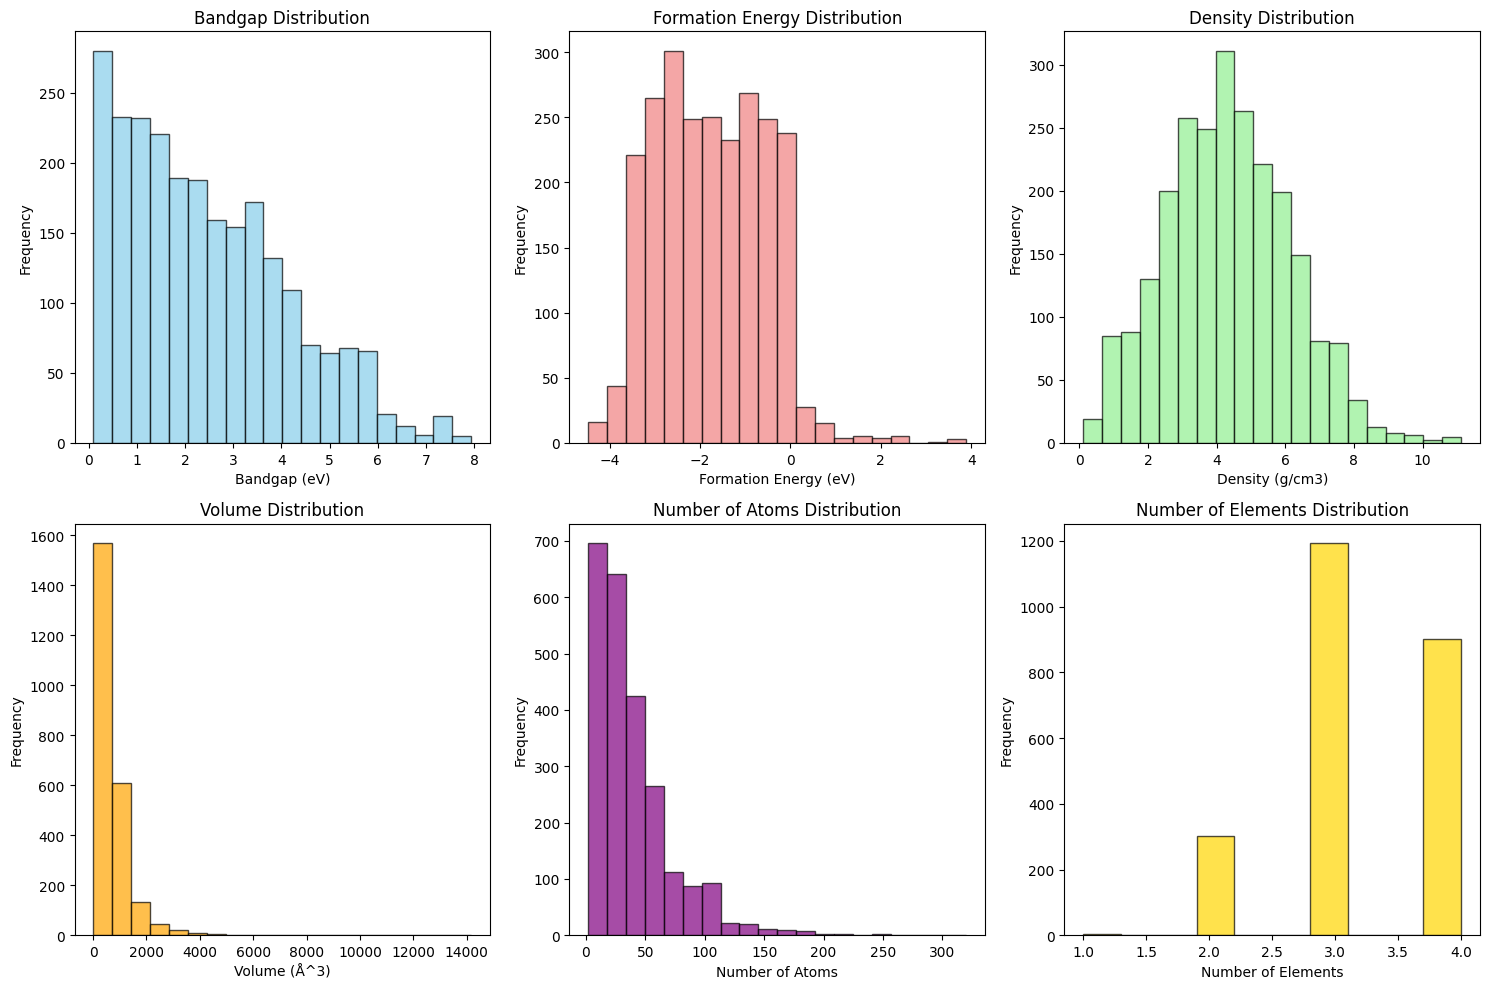

In [53]:
# --- 2. 数据分布可视化 / Visualize Train Data Distributions ---
# 创建一个 2行3列 的画布 / Create a 2x3 subplot grid
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# [0,0] 带隙分布（目标变量）/ Bandgap distribution (target variable)
axes[0,0].hist(train_df['bandgap_eV'], bins=20, alpha=0.7, color='skyblue', edgecolor='black')
axes[0,0].set_title('Bandgap Distribution')
axes[0,0].set_xlabel('Bandgap (eV)')
axes[0,0].set_ylabel('Frequency')

# [0,1] 形成能分布 / Formation energy distribution
axes[0,1].hist(train_df['formation_energy'], bins=20, alpha=0.7, color='lightcoral', edgecolor='black')
axes[0,1].set_title('Formation Energy Distribution')
axes[0,1].set_xlabel('Formation Energy (eV)')
axes[0,1].set_ylabel('Frequency')

# [0,2] 密度分布 / Density distribution
axes[0,2].hist(train_df['density_gcc'], bins=20, alpha=0.7, color='lightgreen', edgecolor='black')
axes[0,2].set_title('Density Distribution')
axes[0,2].set_xlabel('Density (g/cm3)')
axes[0,2].set_ylabel('Frequency')

# [1,0] 体积分布 / Volume distribution
axes[1,0].hist(train_df['volume_A3'], bins=20, alpha=0.7, color='orange', edgecolor='black')
axes[1,0].set_title('Volume Distribution')
axes[1,0].set_xlabel('Volume (Å^3)')
axes[1,0].set_ylabel('Frequency')

# [1,1] 原子数量分布 / Number of atoms distribution
axes[1,1].hist(train_df['n_atoms'], bins=20, alpha=0.7, color='purple', edgecolor='black')
axes[1,1].set_title('Number of Atoms Distribution')
axes[1,1].set_xlabel('Number of Atoms')
axes[1,1].set_ylabel('Frequency')

# [1,2] 元素种类分布 / Number of elements distribution
axes[1,2].hist(train_df['n_elements'], bins=10, alpha=0.7, color='gold', edgecolor='black')
axes[1,2].set_title('Number of Elements Distribution')
axes[1,2].set_xlabel('Number of Elements')
axes[1,2].set_ylabel('Frequency')

plt.tight_layout() # 自动调整子图间距 / Adjust layout to prevent overlap
plt.show()

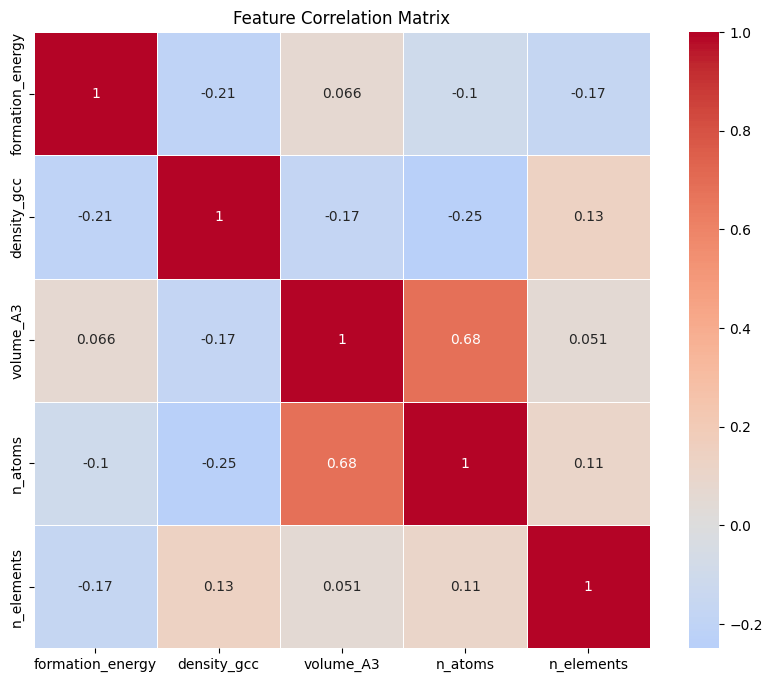

In [54]:
# Correlation Matrix
plt.figure(figsize=(10, 8))

# 自动筛选数值型列 / Automatically select numerical columns
numeric_cols = train_df.select_dtypes(include=[np.number]).columns

# 按照 Screenshot 6 的要求，在分析特征间相关性时剔除目标变量
# Remove the target variable to analyze feature-only correlation
numeric_cols_for_corr = numeric_cols.drop('bandgap_eV')

# 计算相关系数矩阵 / Calculate correlation matrix
correlation_matrix = train_df[numeric_cols_for_corr].corr()

# 使用热力图可视化相关性 / Visualize with a heatmap
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, square=True, linewidths=0.5)
plt.title('Feature Correlation Matrix')
plt.show()